In [2]:
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
scipy 1.0.1
sklearn 0.19.1
pandas 0.22.0
matplotlib 2.1.2


**8장 – 차원 축소**

_이 노트북은 8장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

# 설정

파이썬 2와 3을 모두 지원합니다. 공통 모듈을 임포트하고 맷플롯립 그림이 노트북 안에 포함되도록 설정하고 생성한 그림을 저장하기 위한 함수를 준비합니다:

In [3]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "dim_reduction"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# 투영 방법
3D 데이터셋을 만듭니다:

In [4]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
## Garbage Array 생성
X = np.empty((m, 3)) 
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## SVD 분해를 사용한 PCA

노트: `svd()` 함수는 `U`, `s` 그리고 `Vt`를 반환합니다. 여기에서 `Vt`는 행렬 $\mathbf{V}$의 전치인 $\mathbf{V}^T$입니다.
 - Numpy의 svd 함수로, 훈련 세트의 모든 주성분을 구한 후 처음 두개의 PC를 추출합니다

In [8]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [9]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

- allclose: Returns True if two arrays are element-wise equal within a tolerance

In [10]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [11]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [12]:
X2D_using_svd = X2D

## 사이킷런을 사용한 PCA

사이킷런에서는 PCA가 아주 간단합니다. 데이터셋에서 평균을 빼는 작업도 대신 처리해 줍니다:

In [6]:
from sklearn.decomposition import PCA

#데이터 셋의 차원을 2로 줄이는 코드
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

 - 왜 5번째 Row 까지만 보는걸까? :)


In [14]:
X2D[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [11]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

데이터셋을 조금 다르게해서 PCA를 실행하면 결과가 달라질 것입니다. 일반적으로 달라지는 것은 일부 축이 반대로 바뀌는 정도입니다. 이 예에서 사이킷런의 PCA는 두 축이 반대로 뒤집힌 것외에는 SVD 방식을 사용한 것과 통일한 투영 결과를 만듭니다:

In [15]:
np.allclose(X2D, -X2D_using_svd)

False

평면(PCA 2D 부분공간)에 투영된 3D 포인트를 복원합니다.

In [13]:
X3D_inv = pca.inverse_transform(X2D)

물론, 투영 단계에서 일부 정보를 잃어버리기 때문에 복원된 3D 포인트가 원본 3D 포인트와 완전히 똑같지는 않습니다:

In [14]:
np.allclose(X3D_inv, X)

False

재구성 오차를 계산합니다:
 - 원본 데이터와 재구성된 데이터(압축 후 원복한 것) 사이의 평균 제곱거리를 재구성 오차라고 함

In [15]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.010170337792848549

SVD 방식의 역변환은 다음과 같습니다:

In [16]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

사이킷런의 `PCA` 클래스는 자동으로 평균을 뺏던 것을 복원해주기 때문에 두 방식의 재구성 오차가 동일하지는 않습니다. 하지만 평균을 빼면 동일한 재구성을 얻을 수 있습니다:

In [17]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

`PCA` 객체를 사용하여 계산된 주성분을 참조할 수 있습니다:

In [18]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

SVD 방법으로 계산된 처음 두 개의 주성분과 비교해 보겠습니다:

In [19]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

축이 뒤집힌 것을 알 수 있습니다.

이제 설명된 분산 비율을 확인해 보겠습니다:

In [20]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

첫 번째 차원이 84.2%의 분산을 포함하고 있고 두 번째는 14.6%의 분산을 설명합니다.

2D로 투영했기 때문에 분산의 1.1%을 잃었습니다:

In [21]:
1 - pca.explained_variance_ratio_.sum()

0.011195535570688975

SVD 방식을 사용했을 때 설명된 분산의 비율을 계산하는 방법은 다음과 같습니다(`s`는 행렬 `S`의 대각 성분입니다):

In [22]:
np.square(s) / np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

이를 그래프로 멋지게 그려보죠! :)

3D 화살표를 그래기 위한 유틸리티 클래스입니다(http://stackoverflow.com/questions/11140163 에서 복사했습니다)

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

x와 y의 함수로 평면을 표현합니다.

In [24]:
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

3D 데이터셋, 평면 그리고 이 평면으로의 투영을 그립니다.

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


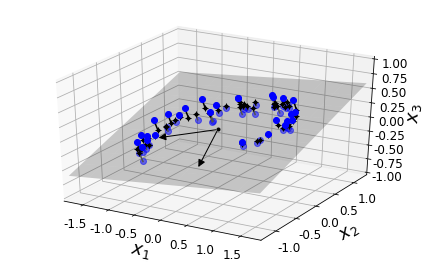

In [25]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X3D_inv[:, 2]]
X3D_below = X[X[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X[i][0], X3D_inv[i][0]], [X[i][1], X3D_inv[i][1]], [X[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("dataset_3d_plot")
plt.show()

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


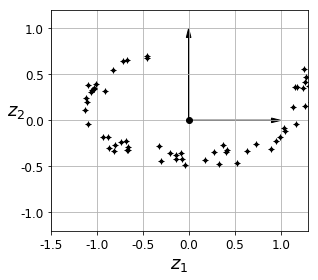

In [26]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)
save_fig("dataset_2d_plot")

# 매니폴드 학습
스위스 롤:

In [27]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


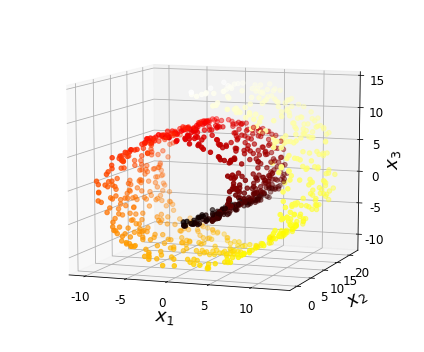

In [28]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


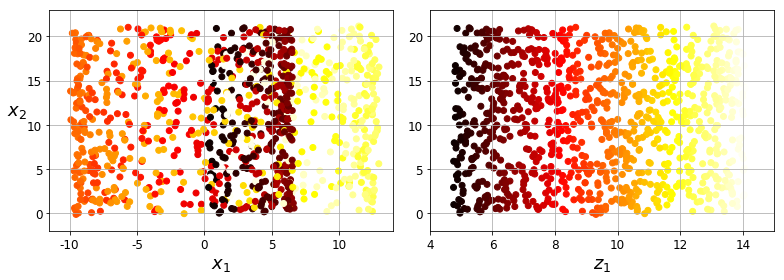

In [29]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


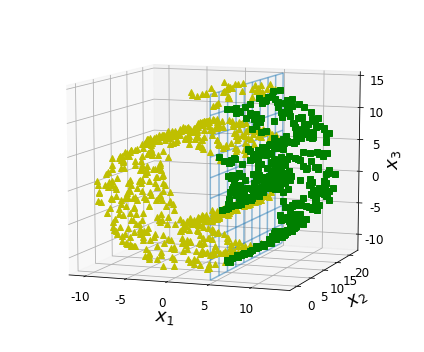

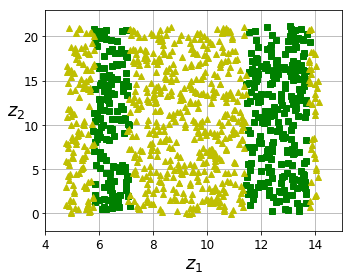

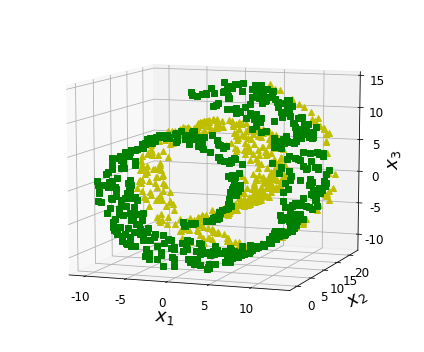

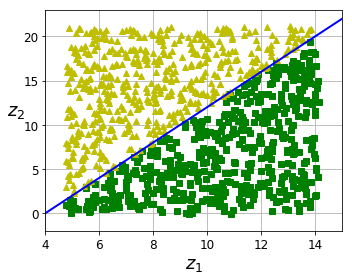

In [30]:
from matplotlib import gridspec

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)

save_fig("manifold_decision_boundary_plot2")
plt.show()

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0, labelpad=7)
plt.grid(True)

save_fig("manifold_decision_boundary_plot4")
plt.show()

# PCA

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


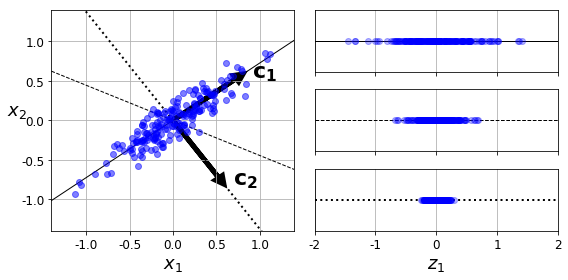

In [31]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

save_fig("pca_best_projection")
plt.show()

# MNIST 압축

In [32]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [33]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [35]:
d

154

In [36]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [37]:
pca.n_components_

154

In [38]:
np.sum(pca.explained_variance_ratio_)

0.9503623084769204

In [39]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

In [40]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


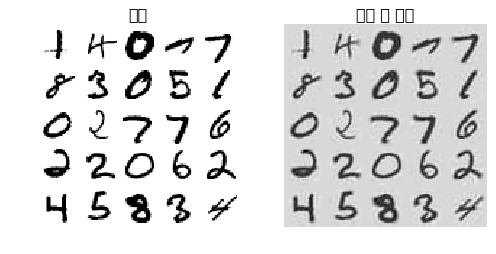

In [41]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("원본", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("압축 후 복원", fontsize=16)

save_fig("mnist_compression_plot")

In [42]:
X_reduced_pca = X_reduced

## 점진적 PCA

In [43]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # not shown in the book
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

....................................................................................................

In [44]:
X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


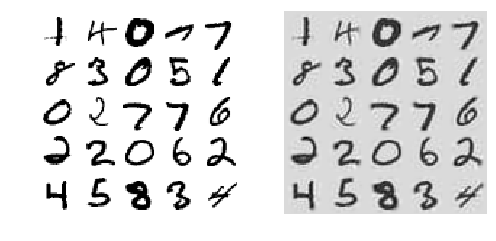

In [45]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.tight_layout()

In [46]:
X_reduced_inc_pca = X_reduced

일반 PCA와 점진적 PCA로 MNIST 데이터를 변환한 결과를 비교해 보겠습니다. 먼저 평균이 같은지 확인합니다: 

In [47]:
np.allclose(pca.mean_, inc_pca.mean_)

True

하지만 결과는 완전히 동일하지 않습니다. 점진적 PCA는 아주 훌륭한 근사치를 제공하지만 완벽하지는 않습니다:

In [48]:
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

### `memmap()` 사용하기

`memmap()` 구조를 만들고 MNIST 데이터를 복사합니다. 이는 일반적으로 별도의 프로그램에서 먼저 수행됩니다:

In [49]:
filename = "my_mnist.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

이제 `memmap()` 객체를 삭제하면 파이썬 종결자(finalizer)를 호출해서 데이터를 디스크에 저장하게 됩니다.

In [50]:
del X_mm

다음에 다른 프로그램에서 데이터를 로드하여 훈련에 사용합니다:

In [51]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [52]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## 시간 복잡도

주성분 개수를 바꾸어가며 점진적 PCA와 랜덤 PCA에 비해 일반 PCA 시간을 재어보겠습니다:

In [53]:
import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.3 seconds
    IncrementalPCA: 22.4 seconds
    PCA: 2.5 seconds
n_components = 10
    PCA: 2.9 seconds
    IncrementalPCA: 21.0 seconds
    PCA: 2.8 seconds
n_components = 154
    PCA: 6.4 seconds
    IncrementalPCA: 40.3 seconds
    PCA: 7.0 seconds


이번에는 데이터셋의 크기(샘플의 수)를 바꾸어가며 일반 PCA와 랜덤 PCA를 비교해 보겠습니다:

Text(0.5,1,'PCA와 랜덤 PCA의 시간 복잡도')

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


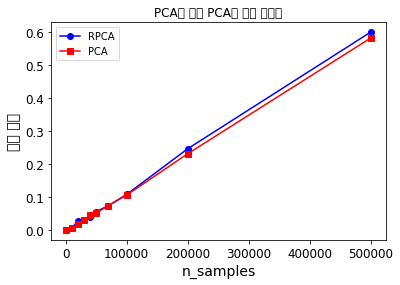

In [54]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components = 2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("훈련 시간")
plt.legend(loc="upper left")
plt.title("PCA와 랜덤 PCA의 시간 복잡도")

이번에는 특성의 개수를 달리하면서 2,000 샘플이 있는 데이터셋에서 성능을 비교해 보겠습니다:

Text(0.5,1,'PCA와 Randomized PCA의 시간 복잡도')

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


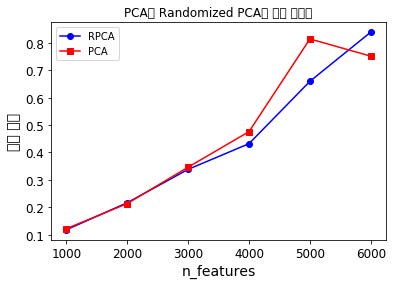

In [55]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("훈련 시간")
plt.legend(loc="upper left")
plt.title("PCA와 Randomized PCA의 시간 복잡도")

# 커널 PCA

In [56]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [57]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\mathtext.py:854: MathTextWarning: Font 'default' does not have a glyph for '\ucee4' [U+cee4]
  MathTextWarning)
C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\mathtext.py:855: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)
C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\mathtext.py:854: MathTextWarning: Font 'default' does not have a glyph for '\ub110' [U+b110]
  MathTextWarning)
C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\mathtext.py:854: MathTextWarning: Font 'default' does not have a glyph for '\uc2dc' [U+c2dc]
  MathTextWarning)
C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\mathtext.py:854: MathTextWarning: Font 'de

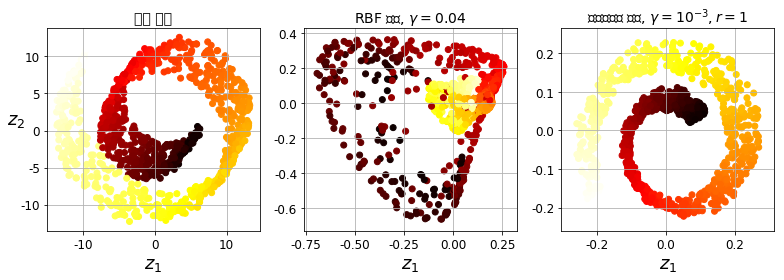

In [58]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "선형 커널"), (132, rbf_pca, "RBF 커널, $\gamma=0.04$"), (133, sig_pca, "시그모이드 커널, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("kernel_pca_plot")
plt.show()

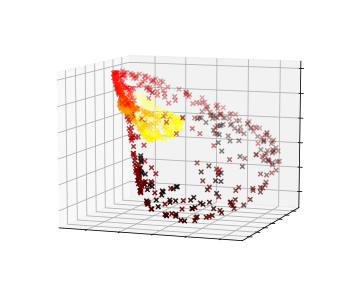

In [59]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])

save_fig("preimage_plot", tight_layout=False)
plt.show()

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


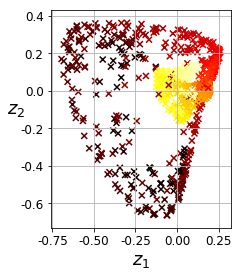

In [60]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(132)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

In [61]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [62]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [63]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [64]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.7863087957661

# LLE

In [65]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [66]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


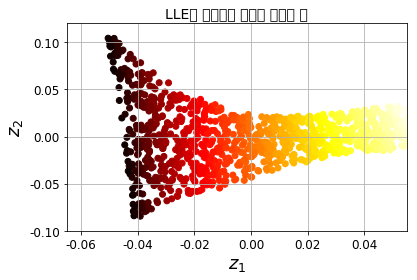

In [67]:
plt.title("LLE를 사용하여 펼쳐진 스위스 롤", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

# MDS, Isomap 그리고 t-SNE

In [68]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

In [69]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

In [71]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist["data"]
y_mnist = mnist["target"]
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

C:\Users\bongh\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\bongh\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1320: UserWarning: findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


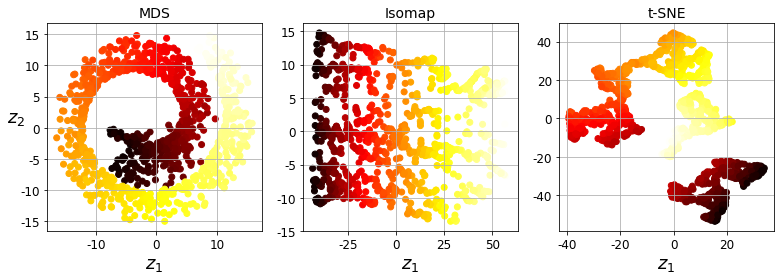

In [72]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# 연습문제 해답

## 1. to 8.

부록 A 참조.

## 9.

*문제: (3장에서 소개한) MNIST 데이터셋을 로드하고 훈련 세트와 테스트 세트로 분할합니다(처음 60,000개는 훈련을 위한 샘플이고 나머지 10,000개는 테스트용입니다).*

In [73]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [74]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

*문제: 이 데이터셋에 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 시간을 잰 다음, 테스트 세트로 만들어진 모델을 평가합니다.*

In [75]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(random_state=42)

In [76]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [77]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 4.40s


In [78]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9455

*문제: 그런 다음 PCA를 사용해 설명된 분산이 95%가 되도록 차원을 축소합니다.*

In [79]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

*문제: 이 축소된 데이터셋에 새로운 랜덤 포레스트 분류기를 훈련시키고 얼마나 오래 걸리는지 확인합니다. 훈련 속도가 더 빨라졌나요?*

In [80]:
rnd_clf2 = RandomForestClassifier(random_state=42)
t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [81]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 10.54s


이런! 훈련이 두 배 이상 느려졌습니다! 어떻게 이럴 수 있죠? 이 장에서 보았듯이 차원 축소는 언제나 훈련 시간을 줄여주지 못합니다. 데이터셋, 모델, 훈련 알고리즘에 따라 달라집니다. 그림 8-6을 참고하세요. 랜덤 포레스트 분류기 대신 소프트맥스 분류기를 적용하면 PCA를 사용해서 훈련 시간을 3배나 줄일 수 있습니다. 잠시 후에 실제로 한번 해보겠습니다. 하지만 먼저 새로운 랜덤 포레스트 분류기의 정밀도를 확인해 보죠.

*문제: 이제 테스트 세트에서 이 분류기를 평가해보세요. 이전 분류기와 비교해서 어떤가요?*

In [82]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.8908

차원 축소를 했을 때 유용한 정보를 일부 잃었기 때문에 성능이 조금 감소되는 것이 일반적입니다. 그렇지만 이 경우에는 성능 감소가 좀 심각한 것 같습니다. PCA가 별로 도움이 되지 않네요. 훈련 시간도 느려지고 성능도 감소했습니다. :(

소프트맥스 회귀를 사용하면 도움이 되는지 확인해 보겠습니다:

In [83]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

In [84]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 31.99s


In [85]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9252

좋네요. 소프트맥스 회귀는 랜덤 포레스트 분류기보다 이 데이터셋에서 훈련하는데 더 많은 시간이 걸리고 테스트 세트에서의 성능도 더 나쁩니다. 하지만 지금 관심 사항은 아닙니다. PCA가 소프트맥스 회귀에 얼마나 도움이 되는지가 궁금합니다. 축소된 데이터셋에 소프트맥스 회귀 모델을 훈련시켜 보겠습니다:

In [86]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

In [87]:
print("훈련 시간: {:.2f}s".format(t1 - t0))

훈련 시간: 8.74s


와우! 차원 축소가 속도를 4배나 빠르게 만들었습니다. :) 모델의 정확도를 확인해 보겠습니다:

In [88]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9198

성능이 조금 감소되었지만 애플리케이션에 따라서 4배 속도 향상의 댓가로 적절한 것 같습니다.

여기서 알 수 있는 것: PCA는 속도를 아주 빠르게 만들어 주지만 항상 그런 것은 아니다!

## 10.

*문제: t-SNE 알고리즘을 사용해 MNIST 데이터셋을 2차원으로 축소시키고 맷플롯립으로 그래프를 그려보세요. 이미지의 타깃 클래스마다 10가지 색깔로 나타낸 산점도를 그릴 수 있습니다.*

MNIST 데이터셋을 (다시) 로드합니다:

In [89]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata('MNIST original')

전체 60,000개의 이미지에 차원 축소를 하면 매우 오랜 시간이 걸리므로 10,000개의 이미지만 무작위로 선택하여 사용하겠습니다:

In [ ]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

이제 t-SNE를 사용해 2D로 차원을 축소해 그래프로 나타냅니다:

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

산점도를 그리기 위해 맷플롯립의 `scatter()` 함수를 사용합니다. 각 숫자마다 다른 색깔을 사용합니다:

In [ ]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

아름답지 않나요? :) 이 그래프는 어떤 숫자가 다른 것과 구분이 쉬운지 알려 줍니다(가령, 0, 6 등이 잘 구분되어 있습니다). 그리고 어떤 숫자가 구분이 어려운지 알려 줍니다(가령, 4, 9입니다).

많이 겹쳐진 것 같은 숫자 4과 9에 집중해 보겠습니다.

In [ ]:
plt.figure(figsize=(9,9))
cmap = matplotlib.cm.get_cmap("jet")
for digit in (4, 9):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=cmap(digit / 9))
plt.axis('off')
plt.show()

이 두 개의 숫자에 t-SNE를 실행시켜 더 나은 이미지를 만들 수 있는지 보겠습니다:

In [ ]:
idx = (y == 4) | (y == 9)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

In [ ]:
plt.figure(figsize=(9,9))
for digit in (4, 9):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=cmap(digit / 9))
plt.axis('off')
plt.show()

훨씬 좋네요. 이제 군집이 덜 겹쳐졌습니다. 하지만 숫자 4가 두 개의 군집으로 나뉘어져 있습니다. 각 군집에 숫자를 몇 개씩 나타내면 훨씬 이해하는기 좋을 것 같습니다. 그렇게 한번 해보죠.

*문제: 또는 샘플의 위치에 각기 다른 색깔의 숫자를 나타낼 수도 있고, 숫자 이미지 자체의 크기를 줄여서 그릴 수도 있습니다(모든 숫자를 다 그리면 그래프가 너무 복잡해지므로 무작위로 선택한 샘플만 그리거나, 인접한 곳에 다른 샘플이 그려져 있지 않은 경우에만 그립니다). 잘 분리된 숫자의 군집을 시각화할 수 있을 것입니다.*

산점도와 색깔있는 숫자를 쓰기위해 `plot_digits()` 함수를 만듭니다. 이 숫자 사이의 거리가 최소가 되도록 합니다. 숫자 이미지가 있다면 대신 이를 사용합니다. 이 코드는 사이킷런의 훌륭한 데모([plot_lle_digits](http://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html), 데이터셋은 다릅니다)를 참고했습니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # 입력 특성의 스케일을 0에서 1 사이로 만듭니다.
    X_normalized = MinMaxScaler().fit_transform(X)
    # 그릴 숫자의 좌표 목록을 만듭니다.
    # 반복문 아래에서 `if` 문장을 쓰지 않기 위해 시작할 때 이미 그래프가 그려져 있다고 가정합니다.
    neighbors = np.array([[10., 10.]])
    # 나머지는 이해하기 쉽습니다.
    plt.figure(figsize=figsize)
    cmap = matplotlib.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=cmap(digit / 9))
    plt.axis("off")
    ax = plt.gcf().gca()  # 현재 그래프의 축을 가져옵니다.
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

시작해 보죠! 먼저 색깔이 입혀진 숫자를 써 보겠습니다:

In [ ]:
plot_digits(X_reduced, y)

꽤 좋습니다. 하지만 아름답지는 않네요. 숫자 이미지를 사용해 보겠습니다:

In [ ]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

In [ ]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

*문제: PCA, LLE, MDS 같은 차원 축소 알고리즘을 적용해보고 시각화 결과를 비교해보세요.*

PCA부터 시작해 보죠. 얼마나 오래 걸리는지도 재어 보겠습니다:

In [ ]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

와우, PCA가 아주 빠르네요! 몇 개의 군집이 보이지만 너무 겹쳐져 있습니다. LLE를 사용해 보죠:

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

시간이 좀 걸리고 결과도 아주 좋지는 않습니다. 분산의 95%를 보존하도록 먼저 PCA를 적용하면 어떻게 되는지 보겠습니다:

In [ ]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

결과는 비슷하지만 걸린 시간은 4배나 줄었습니다.

MDS를 시도해 보죠. 10,000개 샘플을 적용하면 이 알고리즘은 너무 오래걸리므로 2,000개만 시도해 보겠습니다:

In [ ]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 시간: {:.1f}s (10,000개가 아니고 2,000 MNIST 이미지에서).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

아 이건 좋지 않아 보이네요. 모든 군집이 너무 중복되어 있습니다. 먼저 PCA를 적용하면 빨라질까요?

In [ ]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS 시간: {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

같은 결과에 속도도 동일합니다. PCA가 도움이 되지 않네요.

LDA를 시도해 보죠:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

매우 빨라 처음엔 괜찮아 보이지만 자세히 보면 몇 개의 군집이 심각하게 중복되어 있습니다.

아마 이 비교에서 t-SNE가 승자같네요. 시간을 재어 보진 않았으니 한번 해보죠:

In [ ]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

LLE 보다 두 배나 느립니다. 하지만 MDS 보단 훨씬 빠르고 결과물도 아주 좋습니다. PCA가 속도를 높여줄 수 있는지 확인해 보겠습니다:

In [ ]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

네, 결과물에 영향을 미치지 않으면서 PCA 속도가 34% 정도 향상되었습니다. t-SNE가 제일 좋네요!